In [ ]:
devtools::install_github("ClairBarnes/rwwa")
suppressMessages(library("rwwa"))

# Negative binomial distribution for overdispersed count data

In [ ]:
df <- merge(read.table("gmst.txt", col.names = c("year", "gmst")), merge(read.csv("NAO.csv"), read.csv("UKIre_SSI_precip.csv")))

cov_2023 <- df[df$year == 2023,c("gmst", "nao")]; rownames(cov_2023) <- "factual"
cov_cf <- rbind("hist" = data.frame(gmst = -1.2, nao = df$nao[df$year == 2023]),
                "neut" = data.frame(gmst = 0, nao = 0))

## Define NS log-likelihood function

In [ ]:
x <- log(df$SSI_count)
cov <- df[,c("gmst"),drop = F]

loc <- mean(x)
scale <- sqrt(var(x))

init <- c("mu0" = mean(x), "sigma0" = sd(x), "alpha_gmst" = 0)

# parametrize via dispersion & mean

In [ ]:
ll_nbinom <- function (pars, fixed_cov, x) { 
        
    effect_a <- rowSums(matrix(sapply(names(fixed_cov), function(cnm) pars[paste0("alpha_",cnm)] * fixed_cov[,cnm]), nrow = nrow(fixed_cov)))
    ns_const = exp(effect_a / pars["mu0"])
                                      
#     # log-link function needed
#     loc = exp(pars["mu0"] + effect_a)
#     scale = exp(rep(pars["sigma0"], length(loc)))
                                      
#     # log link with fixed dispersion
#     loc = exp(pars["mu0"] * ns_const)
#     scale = exp(rep(pars["sigma0"] * ns_const, length(loc)))
                                      
#     # log link with fixed dispersion (2)
#     loc = exp(pars["mu0"]) * ns_const
#     scale = exp(rep(pars["sigma0"], length(loc))) * ns_const
                                      
    # log-link function handled by transforming x, not parameters
    loc = pars["mu0"] * effect_a
    scale = rep(pars["sigma0"], length(loc))
    
    -sum(dnbinom(x, mu = loc, size = scale^2/loc, log = T)) 
}

fitted <- suppressWarnings(optim(par = init, ll_nbinom, fixed_cov = cov, x = x))

In [ ]:
fitted$par
aic(fitted)

In [127]:
coef(glm.nb(SSI_count ~ gmst, df))
AIC(glm.nb(SSI_count ~ gmst, df))

(Intercept)        gmst 
 2.90239880 -0.06656395

[1] 451.7335

In [125]:
sd(resid(glm.nb(SSI_count ~ gmst, df)))

[1] 0.9986245

In [40]:
m = mean(df$SSI_count); v = var(df$SSI_count); d = v/m; dnbinom(x <- seq(0,40), size = (m/(d-1)), mu = m)

(Intercept) 
   2.881069

[1] 1.754184e-06 1.774616e-05 9.360387e-05 3.426500e-04 9.778064e-04
 [6] 2.316885e-03 4.741922e-03 8.611873e-03 1.415095e-02 2.134944e-02
[11] 2.991263e-02 3.927714e-02 4.869189e-02 5.734080e-02 6.447501e-02
[16] 6.952371e-02 7.216252e-02 7.233237e-02 7.021356e-02 6.616872e-02
[21] 6.067067e-02 5.423061e-02 4.733745e-02 4.041453e-02 3.379506e-02
[26] 2.771436e-02 2.231486e-02 1.765950e-02 1.374915e-02 1.054069e-02
[31] 7.963630e-03 5.933702e-03 4.363278e-03 3.168474e-03 2.273498e-03
[36] 1.612819e-03 1.131738e-03 7.859287e-04 5.403705e-04 3.680044e-04
[41] 2.483349e-04

In [53]:
mdl_nb <- glm.nb(SSI_count ~ 1, df)
E_storms <- predict(mdl_nb, newdata = rbind(cov_2023, cov_cf), type = "response")

In [57]:
coef(glm.nb(SSI_count ~ 1, df))

(Intercept) 
   2.881069

In [50]:
r <- m^2/(v-m); p <- m/v

In [51]:
r*(1-p)/p

[1] 17.83333

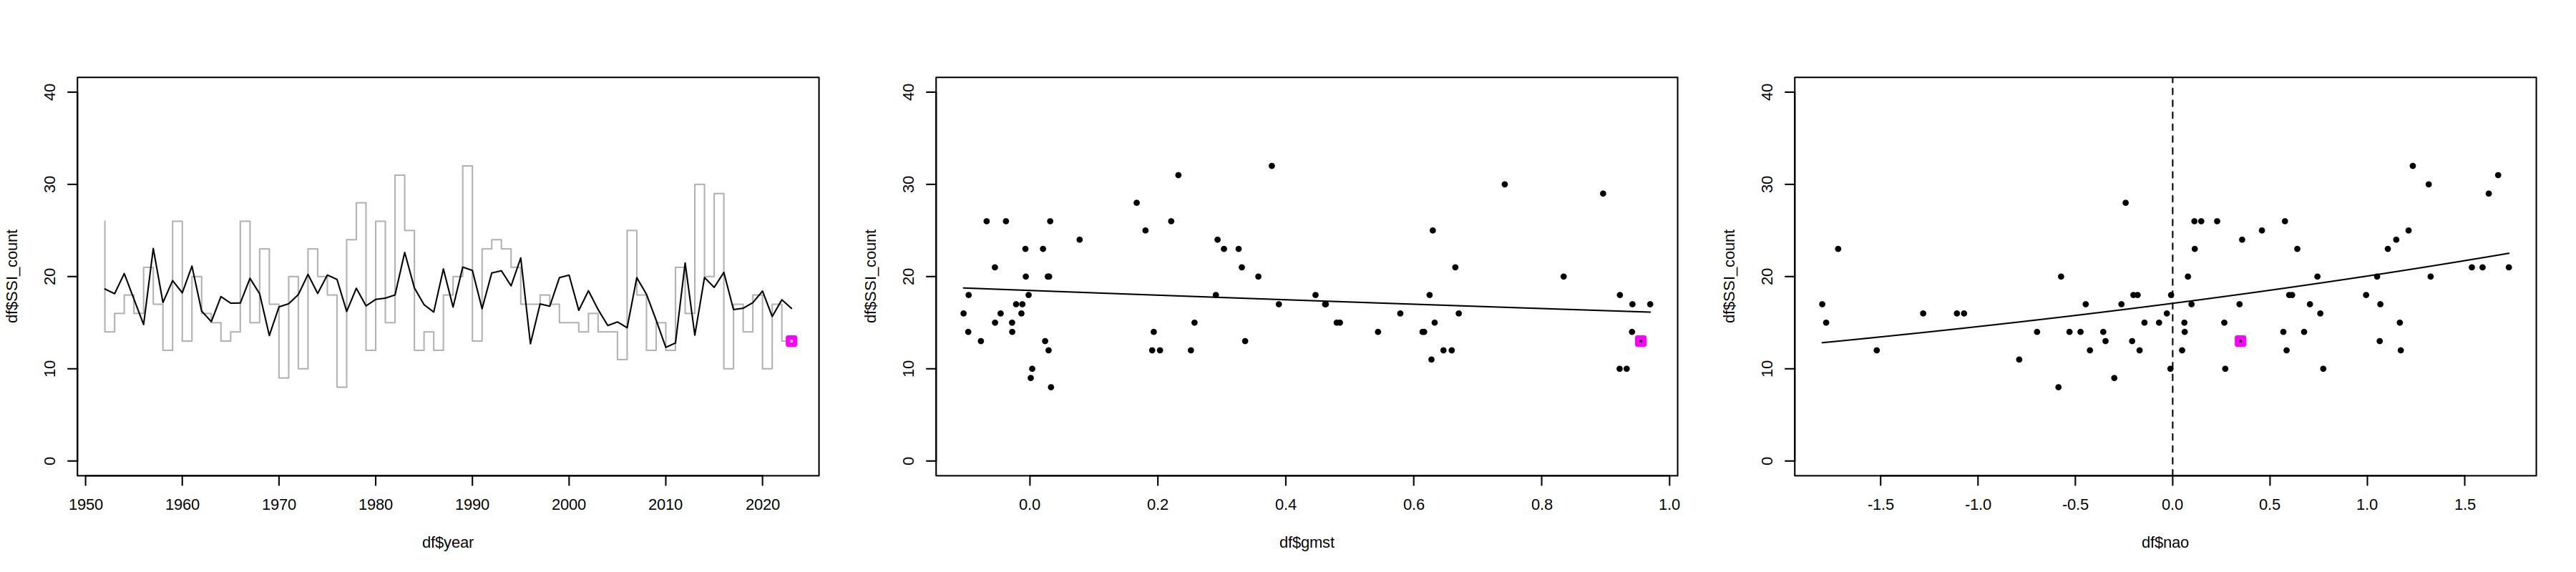

In [32]:
prep_window(c(1,3), w = 6)
ylim <- range(x)

plot(df$year, df$SSI_count, type = "S", col = adjustcolor("black", 0.3), ylim = ylim)
lines(df$year, fitted(mdl_nb))
points(df[df$year == 2023,c("year", "SSI_count")], col = "magenta", pch = 0, lwd = 3)
# lines(df$year, add_quantile(df, mdl_nb, p = c(0.9))[,"quantile0.9"], lty = 2, col = "blue")


xcov <- df$gmst[order(df$gmst)]
cov_df <- data.frame(SSI_count = df$SSI_count, gmst = xcov, nao = mean(df$nao))
plot(df$gmst, df$SSI_count, ylim = ylim)
lines(xcov, predict(mdl_nb, newdata = cov_df, type = "response"))
points(df[df$year == 2023,c("gmst", "SSI_count")], col = "magenta", pch = 0, lwd = 3)
# lines(xcov, add_quantile(cov_df, mdl_nb, p = c(0.9))[,"quantile0.9"], lty = 2, col = "blue")

xcov <- df$nao[order(df$nao)]
cov_df <- data.frame(SSI_count = df$SSI_count, gmst = mean(df$gmst), nao = xcov)
plot(df$nao, df$SSI_count, ylim = ylim)
lines(xcov, predict(mdl_nb, newdata = cov_df, type = "response"))
abline(v = 0, lty = 2)
points(df[df$year == 2023,c("nao", "SSI_count")], col = "magenta", pch = 0, lwd = 3)
# lines(xcov, add_quantile(cov_df, mdl_nb, p = c(0.9))[,"quantile0.9"], lty = 2, col = "blue")